In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [2]:
from numba import njit

M = 20
N = 40

mh = 4 / M
nh = 3 / N

@njit
def x(i):
    return mh*i

@njit
def y(j):
    return nh*j

@njit
def k(x, y):
    return 4 + x + y

@njit
def q(x, y):
    return max(0, x + y)

@njit
def u(x, y):
    return np.sqrt(4 + x*y)

@njit
def F(x, y):
    return (x**3 - x**2*(y-4) - x*(y**2 + 8) + y*(y**2 + 4*y - 8) + 4*max(0, x + y)*(4 + x*y)**2)/4/(4+x*y)**(3/2)

@njit
def psi_top(x):
    return x*(4+x+3)/2/np.sqrt(4+x*3)

@njit
def psi_bottom(x):
    return -x*(4+x+0)/2/np.sqrt(4+x*0)
    
@njit
def psi_right(y):
    return y*(4+4+y)/2/np.sqrt(4+4*y) + np.sqrt(4 + 4*y)

@njit
def psi_left(y):
    return -y*(4+0+y)/2/np.sqrt(4+0*y) + np.sqrt(4 + 0*y)
    
@njit
def A_dot(w):
    def mw_right(w, i, j):
        return k(x(i) + mh/2, y(j))*(w[i + 1, j] - w[i, j])/mh**2
    
    def mw_left(w, i, j):
        return -k(x(i) - mh/2, y(j))*(w[i, j] - w[i - 1, j])/mh**2
    
    def nw_top(w, i, j):
        return k(x(i), y(j) + nh/2)*(w[i, j + 1] - w[i, j])/nh**2
    
    def nw_bottom(w, i, j):
        return -k(x(i), y(j) - nh/2)*(w[i, j] - w[i, j - 1])/nh**2
    
    def mw(w, i, j):
        return mw_right(w, i, j) + mw_left(w, i, j)

    def nw(w, i, j):
        return nw_top(w, i, j) + nw_bottom(w, i, j)
    
    w = w.reshape(M + 1, N + 1)
    Aw = np.zeros_like(w)
    
    for i in range(1, M):
        for j in range(1, N):
            Aw[i, j] = -(mw(w, i, j) + nw(w, i, j)) + q(x(i), y(j))*w[i, j]
            
    for j in range(1, N):
        Aw[M, j] = -mw_left(w, M, j) - nw(w, M, j) + q(x(M), y(j))*w[M, j] + w[M, j]/mh
        Aw[0, j] = -mw_right(w, 0, j) - nw(w, 0, j) + q(x(0), y(j))*w[0, j] + w[0, j]/mh
    
    for i in range(1, M):
        Aw[i, N] = -nw_bottom(w, i, N) - mw(w, i, N) + q(x(i), y(N))*w[i, N]
        Aw[i, 0] = -nw_top(w, i, 0) - mw(w, i, 0) + q(x(i), y(0))*w[i, 0]
        
    Aw[0, 0] = -mw_right(w, 0, 0) - nw_top(w, 0, 0) + q(x(0), y(0))*w[0, 0] + w[0, 0]/mh
    Aw[0, N] = -mw_right(w, 0, N) - nw_bottom(w, 0, N) + q(x(0), y(N))*w[0, N] + w[0, N]/mh
    Aw[M, 0] = -mw_left(w, M, 0) - nw_top(w, M, 0) + q(x(M), y(0))*w[M, 0] + w[M, 0]/mh
    Aw[M, N] = -mw_left(w, M, N) - nw_bottom(w, M, N) + q(x(M), y(N))*w[M, N] + w[M, N]/mh
    
    return Aw.flatten()

b = np.zeros((M + 1, N + 1))
for i in range(1, M):
    for j in range(1, N):
        b[i, j] = F(x(i), y(j))

for j in range(1, N):
    b[M, j] = F(x(M), y(j)) + psi_right(y(j))/mh
    b[0, j] = F(x(0), y(j)) + psi_left(y(j))/mh

for i in range(1, M):
    b[i, N] = F(x(i), y(N)) + psi_top(x(i))/nh
    b[i, 0] = F(x(i), y(0)) + psi_bottom(x(i))/nh

b[0, 0] = F(x(0), y(0)) + psi_left(y(0))/mh + psi_bottom(x(0))/nh
b[0, N] = F(x(0), y(N)) + psi_left(y(N))/mh + psi_top(x(0))/nh
b[M, 0] = F(x(M), y(0)) + psi_right(y(0))/mh + psi_bottom(x(M))/nh
b[M, N] = F(x(M), y(N)) + psi_right(y(N))/mh + psi_top(x(M))/nh
b = b.flatten()

In [3]:
xs = [x(i) for i in range(M + 1)]
ys = [y(j) for j in range(N + 1)]
w_true = np.array([[u(x(i), y(j)) for j in range(N + 1)] for i in range(M + 1)])

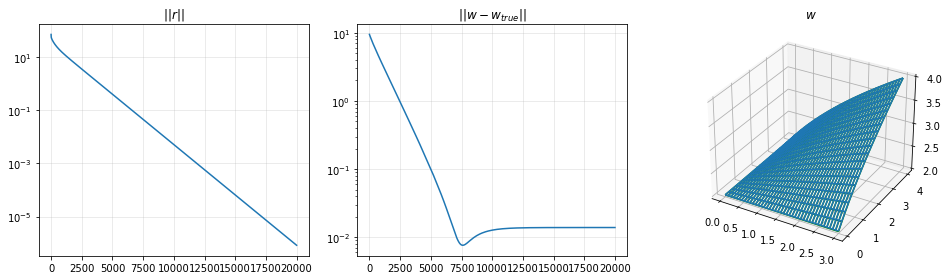

In [4]:
from IPython.display import clear_output
losses = []
diffs = []
verbose = 1000
maxiter = 20_000

w = np.zeros((M + 1)*(N + 1))
for niter in range(maxiter):
    r = A_dot(w) - b
    Ar = A_dot(r)
    
    tau = Ar.dot(r)/Ar.dot(Ar)
    w -= tau*r
    
    losses.append(np.linalg.norm(r)*np.sqrt(nh*mh))
    diffs.append(np.linalg.norm(w - w_true.flatten())*np.sqrt(nh*mh))
    
    if ((niter + 1) % verbose == 0) or (niter == maxiter - 1):
        fig = plt.figure(figsize=plt.figaspect(0.3))
        fig.add_subplot(131)
        plt.semilogy(losses)
        plt.title('$||r||$')
        plt.grid(alpha=0.3)
        
        fig.add_subplot(132)
        plt.semilogy(diffs)
        plt.title('$||w - w_{true}||$')
        plt.grid(alpha=0.3)
        
        ax = fig.add_subplot(133, projection='3d')
        ax.plot_wireframe(*np.meshgrid(ys, xs), w.reshape(w_true.shape), label='$w$')
        ax.plot_wireframe(*np.meshgrid(ys, xs), w_true, color='green', label='$w_{true}$')
        ax.set_title('$w$')

        plt.tight_layout()
        clear_output()
        plt.show()